In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
from sklearn import metrics

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# 1. TCA function defining

In [2]:
def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')


def flat2vec(df):
    # df contains index and column tags
    # function: flatten a df (has 2 dimensions) to a 1D vector
    # the df data properties:
    # [[d1t1 d1t2 d1t3]
    #  [d2t1 d2t2 d2t3]
    #  [d3t1 d3t2 d3t3]]
    # dntn means day n time n
    
    # returned vector: 1D
    return np.array(df.loc[1:, 1:96].astype(float)).reshape(-1, 1).flatten()


def normalize(V):
    return ( V - np.mean(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [3]:
def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    train_x = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    train_y = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert train_x.shape[0] == train_y.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return train_x.T, train_y.T



In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

# 2. Learning Part

## 2.a. Load Data

In [6]:
src_domain = np.array(pd.read_csv('data/site8700_1_20210101_20210131.csv'))[:10, :]  # leeds
data_target = np.array(pd.read_csv('data/siteM4_2210B_20210101_20210131.csv'))  # london

date_choosen = np.arange(4,6,1)
tar_domain = data_target[date_choosen, :].reshape(-1, 96)
tgt_validation = data_target[date_choosen[-1]:date_choosen[-1]+3, :].reshape(-1, 96)

### 2.a.i. preview data

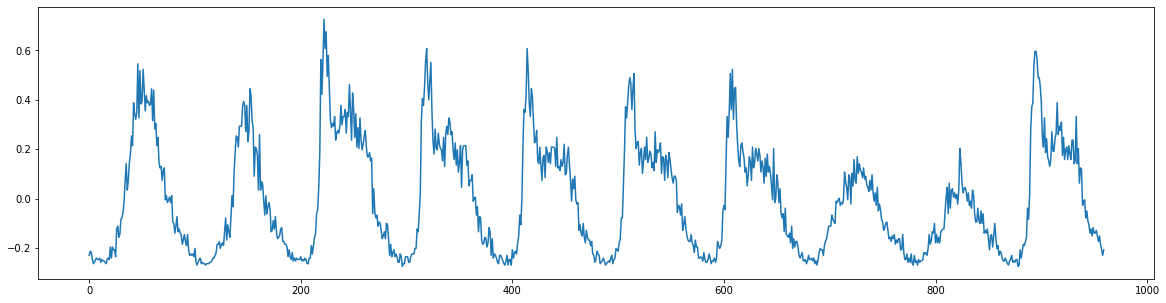

In [7]:
src_domain_emd = normalize(src_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(src_domain_emd)
tar_domain_emd = normalize(tar_domain.flatten())

## 2.b. Extract Features using EMD

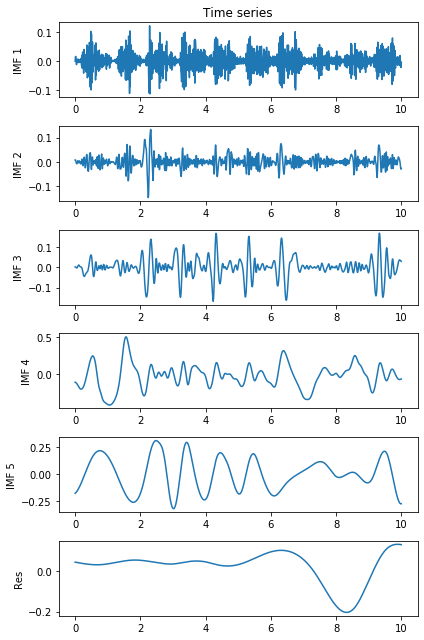

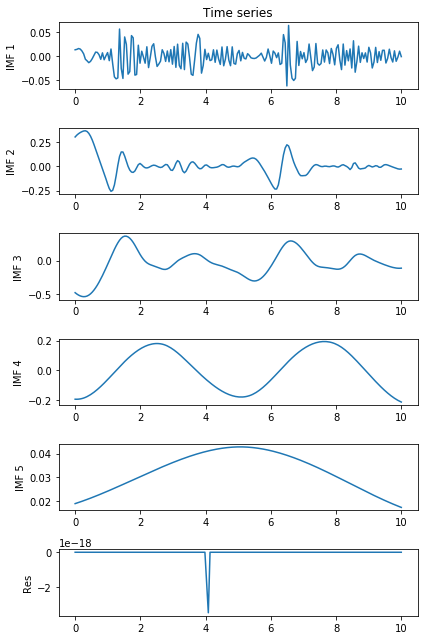

In [8]:
emd = EMD()
emd.emd(src_domain_emd, max_imf=5)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, 10, src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=5)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, 10, tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()


### 2.b.i. assemble Xs and Xt

Data type of **Xs**: [normalized_raw_data (fisrt row); emd_results (rest rows)]

In [9]:
#data_dim = min(imfs_src.shape[0], imfs_tar.shape[0])  # to be verified ***********************
Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])

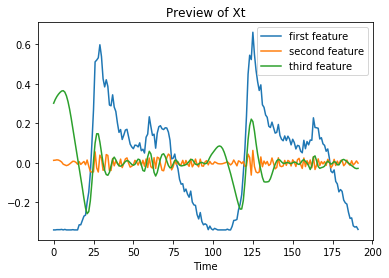

In [10]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()

## 2.c. Hyperparameters

In [11]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 9
reduced_dim = 1
hid_dim = 16
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

## 2.d. Apply Domain Adaptation using TCA (see part 1) upon Xs and Xt

In [12]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,7,7,1,9,1,16,3,3


In [13]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

tca = TCA(kernel_type='linear', dim=seq_len, lamb=lamb, gamma=1)
Xs_new, Xt_new, A = tca.fit(Xs.T, Xt.T)
Xs_new, Xt_new = Xs_new.T, Xt_new.T

print(Xs_new.shape)
print(Xt_new.shape)

(9, 960)
(9, 192)


## 2.e. The LSTM network, hyperparameters see part 2.a.

In [14]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.1)
        
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_dim)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y)  # fully connected layer
        
        return y[-1, :, :]



In [15]:
def assemble(X):
    '''
    X = torch.tensor(X)
    batch_num = X.shape[0] // (seq_len*batch_size)
    new_X = torch.zeros(seq_len, batch_size, dim, batch_num)
    for i in range(batch_num):
        for j in range(batch_size):
            #ipdb.set_trace()
            new_X[:, j, :, i] = X[seq_len*(i*j+j):seq_len*(i*j+j+1), :]
    '''
    new_X = X[:, :, np.newaxis]
    return new_X

## 2.e.i. assemble data and build model

Note: **Xs** is the result of EMD, and is designated for TCA to generate **Xs_new**

**src_domain** and **tar_domain** are the raw data sets



In [16]:
batch_size = Xs_new.shape[1] + Xt_new.shape[1] + 2 * (- seq_len - label_seq_len + 1)
train_x = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
train_y = np.zeros([ label_seq_len, batch_size, label_dim ])

test_data_num = Xt_new.shape[1] - seq_len - label_seq_len + 1
target_x = np.zeros([ seq_len, test_data_num, inp_dim ])
target_y = np.zeros([ label_seq_len, test_data_num, label_dim ])


for i in range(inp_dim):
    x_i_src, y_i_src = sliding_window(Xs_new[i, :], Xs[i, :], seq_len, label_seq_len)  # i means i^th dim
    x_i_tar, y_i_tar = sliding_window(Xt_new[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim
    
    train_x[:, :, i] += np.concatenate([x_i_src, x_i_tar], axis=1)
    train_y[:, :, i] += np.concatenate([y_i_src, y_i_tar], axis=1)
    target_x[:, :, i] += x_i_tar
    target_y[:, :, i] += y_i_tar
    

# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(inp_dim, label_dim, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)


train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
target_x = torch.tensor(target_x, dtype=torch.float32, device=device)
target_y = torch.tensor(target_y, dtype=torch.float32, device=device)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


## 2.e.ii. train

In [17]:
# train
num_epoch = 5001

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net(train_x)

    loss = (out - train_y[0, :, :]) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%100==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()
        

Epoch:    0, Loss: 0.0370596
Epoch:  100, Loss: 0.0022400
Epoch:  200, Loss: 0.0013393
Epoch:  300, Loss: 0.0010106
Epoch:  400, Loss: 0.0008777
Epoch:  500, Loss: 0.0007901
Epoch:  600, Loss: 0.0007315
Epoch:  700, Loss: 0.0006952
Epoch:  800, Loss: 0.0006418
Epoch:  900, Loss: 0.0006141
Epoch: 1000, Loss: 0.0005707
Epoch: 1100, Loss: 0.0005405
Epoch: 1200, Loss: 0.0005042
Epoch: 1300, Loss: 0.0005078
Epoch: 1400, Loss: 0.0004745
Epoch: 1500, Loss: 0.0004710
Epoch: 1600, Loss: 0.0004554
Epoch: 1700, Loss: 0.0004104
Epoch: 1800, Loss: 0.0004124
Epoch: 1900, Loss: 0.0003980
Epoch: 2000, Loss: 0.0003761
Epoch: 2100, Loss: 0.0003776
Epoch: 2200, Loss: 0.0003477
Epoch: 2300, Loss: 0.0003508
Epoch: 2400, Loss: 0.0003350
Epoch: 2500, Loss: 0.0003373
Epoch: 2600, Loss: 0.0003375
Epoch: 2700, Loss: 0.0003303
Epoch: 2800, Loss: 0.0003105
Epoch: 2900, Loss: 0.0003049
Epoch: 3000, Loss: 0.0002885
Epoch: 3100, Loss: 0.0003111
Epoch: 3200, Loss: 0.0003095
Epoch: 3300, Loss: 0.0002853
Epoch: 3400, L

## 2.e.iii. test

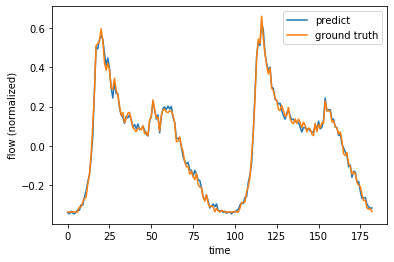

In [18]:
pred_y = net(target_x)
plt.plot(pred_y.detach().numpy()[:, 0], label='predict')
plt.plot(target_y.detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()

In [19]:
train_x.shape

torch.Size([9, 1134, 6])

# 3. Post Analysis, Test

In [20]:
def mape(actual, predict): 
    tmp, n = 0.0, 0
    for i in range(0, len(actual)):
        if actual[i] != 0:
            tmp += math.fabs((actual[i]-predict[i])/(actual[i]+1))
            n += 1
    return (tmp/n)

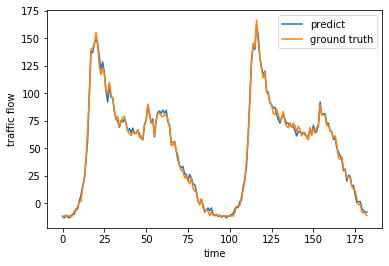

In [23]:
ground_truth_denorm = tar_domain_emd[9:]*(max(src_domain.flatten()) - min(src_domain.flatten())) +np.mean(src_domain.flatten())
pred_y_denorm = pred_y.detach().numpy()[:, 0]*(max(src_domain.flatten()) - min(src_domain.flatten())) +np.mean(src_domain.flatten())

plt.plot(pred_y_denorm, label='predict')
plt.plot(ground_truth_denorm, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()

In [24]:
MSE = metrics.mean_squared_error(ground_truth_denorm, pred_y_denorm)
MAE = metrics.mean_absolute_error(ground_truth_denorm, pred_y_denorm)
MAPE = mape(ground_truth_denorm, pred_y_denorm)
SMAPE2 = np.sum(np.abs(ground_truth_denorm - pred_y_denorm)) / np.sum(ground_truth_denorm + pred_y_denorm)
R2 = 1 - np.sum((ground_truth_denorm - pred_y_denorm)**2) / np.sum((ground_truth_denorm - np.mean(ground_truth_denorm))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)

MSE: 8.630978874052001
MAE: 2.2923762123212508
MAPE: 0.36003407905497387
SMAPE2: 0.022028600048521342
R2: 0.995720942308426


# 4. Train Only Use Target Data Set

In [49]:
target_x_train, target_y_train = sliding_window(normalize(tar_domain), normalize(tar_domain), seq_len, label_seq_len)
target_x_test, target_y_test = sliding_window(normalize(tgt_validation), normalize(tgt_validation), seq_len, label_seq_len)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [50]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2 = LSTM(inp_dim=1, out_dim=1, hid_dim=hid_dim, layers=layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)


target_x_train = torch.tensor(target_x_train[:, :, np.newaxis], dtype=torch.float32, device=device)
target_y_train = torch.tensor(target_y_train[:, :, np.newaxis], dtype=torch.float32, device=device)
target_x_test = torch.tensor(target_x_test[:, :, np.newaxis], dtype=torch.float32, device=device)
target_y_test = torch.tensor(target_y_test[:, :, np.newaxis], dtype=torch.float32, device=device)

In [51]:
# train
num_epoch = 5000

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net2(target_x_train)

    loss = (out - target_y_train[0, :, :]) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%100==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()

Epoch:    0, Loss: 0.0650936
Epoch:  100, Loss: 0.0652172
Epoch:  200, Loss: 0.0650934
Epoch:  300, Loss: 0.0650187
Epoch:  400, Loss: 0.0651348
Epoch:  500, Loss: 0.0649888
Epoch:  600, Loss: 0.0650782
Epoch:  700, Loss: 0.0650601
Epoch:  800, Loss: 0.0651255
Epoch:  900, Loss: 0.0651139
Epoch: 1000, Loss: 0.0651087
Epoch: 1100, Loss: 0.0650697
Epoch: 1200, Loss: 0.0651359
Epoch: 1300, Loss: 0.0651509
Epoch: 1400, Loss: 0.0652190
Epoch: 1500, Loss: 0.0651338
Epoch: 1600, Loss: 0.0650591
Epoch: 1700, Loss: 0.0651599
Epoch: 1800, Loss: 0.0649835
Epoch: 1900, Loss: 0.0651404
Epoch: 2000, Loss: 0.0651520
Epoch: 2100, Loss: 0.0650881
Epoch: 2200, Loss: 0.0651257
Epoch: 2300, Loss: 0.0650508
Epoch: 2400, Loss: 0.0651446
Epoch: 2500, Loss: 0.0650685
Epoch: 2600, Loss: 0.0651149
Epoch: 2700, Loss: 0.0651389
Epoch: 2800, Loss: 0.0651338
Epoch: 2900, Loss: 0.0651199
Epoch: 3000, Loss: 0.0651542
Epoch: 3100, Loss: 0.0651201
Epoch: 3200, Loss: 0.0650524
Epoch: 3300, Loss: 0.0649919
Epoch: 3400, L

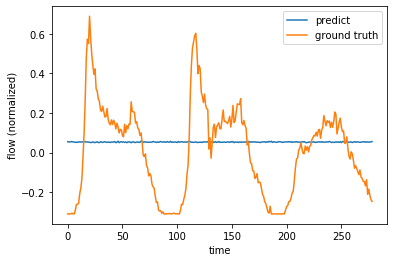

In [52]:
pred_y = net2(target_x_test)
plt.plot(pred_y.detach().numpy()[:, 0], label='predict')
plt.plot(target_y_test.detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()

In [42]:
out.shape

torch.Size([183, 1])